In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import pgeocode
import sys
!{sys.executable} -m pip install geopy
import geopy.distance as gp
import numpy as np
import scipy.stats as stats


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


## Census Data

Data on the quantities of tax returns originating from various ZIP codes. Splits the data into buckets of income, and encodes the returns based on what income bucket it falls under: 
- 1: $1-$25,000
- 2: $25,000-$50,000
- 3: $50,000-$75,000
- 4: $75,000-$100k
- 5: $100k-$200k
- 6: $200k+

We reformat the dataframe by selecting and renaming columns of interest



In [2]:
import pandas as pd


def calculate_wealth_proportions(census_data_file, zip_codes= None):
    """
    Calculates the proportion of tax returns in each zip code that have an income over $100k
    using data from a census data file and a list of zip codes.

    Args:
    - census_data_file (str): the file path to the census data file (in CSV format) with the following columns:
        - zipcode (int): the zip code of the location
        - MARS4 (int): the number of households that are married filing jointly with dependent children
        - mars1 (int): the number of single filers
        - MARS2 (int): the number of households that are married filing jointly without dependent children
        - A00200 (int): the total wages and salaries of the returns
        - agi_stub (int): the income bracket of the return
        - N1 (int): the number of returns
        - STATE (int): the state code of the location
    - zip_codes (list) OPTIONAL : a list of zip codes to calculate the proportion of wealthy tax returns for

    Returns:
    - df (DataFrame): a DataFrame with the following columns:
        - state (str): the state of the zip code
        - zipcode (int): the zip code to calculate the proportion of wealthy tax returns for
        - wealthy_prop (float): the proportion of tax returns in the zip code with an income over $100k
    If zip_codes is not None, the DataFrame will only contain the rows with the zip codes in zip_codes.    
    """
    df = pd.read_csv(census_data_file)[[
        "zipcode", 
        "MARS4", 
        "mars1", 
        "MARS2", 
        "A00200",  
        "agi_stub", 
        "N1", 
        "STATE"
    ]]
    
    df = df.rename(columns={
        "MARS4": "hoh",
        "mars1": "singles",
        "MARS2": "joint",
        "A00200": "wage",
        "N1": "returns",
        "agi_stub": "income",
        "STATE": "state"
    })

    df.state = df.state.astype(str)

    df = df[(df["zipcode"] != 99999) & (df["zipcode"] != 0)]

    df = df[["zipcode", "income", "returns","state"]]
    df = df.pivot(index=["state","zipcode"], columns="income", values='returns').reset_index()

    df.columns = df.columns.astype(str)
    df["wealth"] = df["5"] + df["6"]
    df["all"] = df["1"] + df["2"] + df["3"] + df["4"] + df["5"] + df["6"] 
    df["wealthy_prop"] = round(df["wealth"] / df["all"], 2)

    if zip_codes:
        df = df[df["zipcode"].isin(zip_codes)][["state", "zipcode", "wealthy_prop"]]
    return df



# For getting top n percentile data for use in Streamlit


In [6]:
# given a dataframe, order by the "wealthy_prop" column and return the top n percentile of records by wealthy proportion based on the length of the df. 
def get_top_n_percentile(df, n):
    """
    Given a dataframe, order by the "wealthy_prop" column and return the top n percentile of records by wealthy proportion

    Args:
    - df (DataFrame): the dataframe to filter
    - n (float): the percentile to filter by

    Returns:
    - df (DataFrame): the filtered dataframe
    """
    df = df.sort_values(by=["wealthy_prop"], ascending=False)
    df = df.head(int(len(df) * n))
    return df

def add_lat_long_to_dataframe(dataframe, zipcode_col='zipcode'):
    """
    Adds latitude and longitude columns to a dataframe based on the zip code column

    Args:
        dataframe (pd df): the dataframe to add the columns to
        zipcode_col (str, optional): name of the column for the zip code. Defaults to 'zipcode'.
    """
    def get_lat_long(zipcode):
        zipcode = str(zipcode)
        nomi = pgeocode.Nominatim('US')
        df = nomi.query_postal_code(zipcode)
        return df["latitude"], df["longitude"]

    dataframe['latitude'], dataframe['longitude'] = zip(*dataframe[zipcode_col].apply(get_lat_long))
    return dataframe



df = calculate_wealth_proportions("/Users/tylerkim/verijet/census.csv")


t10 = get_top_n_percentile(df, 0.1)
t10 = add_lat_long_to_dataframe(t10)
t5 = get_top_n_percentile(df, 0.05)
t10 = add_lat_long_to_dataframe(t5)
t1 = get_top_n_percentile(df, 0.01)
t1 = add_lat_long_to_dataframe(t1)

t10.to_csv("10p_zips.csv")
t5.to_csv("5p_zips.csv")
t1.to_csv("1p_zips.csv")

# For doing analysis with GAds data


In [16]:
campaign_zips = {
    94027:"ZIP_SanMateoCountyCA",
    94028: "Zips_SanMateoCountyCA" ,
    90272 :"ZIP_LosAngelesCA",
    90274:"ZIP_LosAngelesCA",
    91436:"ZIP_LosAngelesCA",
    89138:"ZIP_LasVegasNV",
    92009:"ZIP_CarlsbadCA",
    92001:"ZIP_CarlsbadCA",
    92014:"ZIP_RanchoSantaFeCA",
    92075:"ZIP_RanchoSantaFeCA",
    92127:"ZIP_RanchoSantaFeCA",
    92130:"ZIP_RanchoSantaFeCA",
    94105:"ZIP_SanFranciscoCA",
    94107:"ZIP_SanFranciscoCA",
    94114:"ZIP_SanFranciscoCA",
    94123:"ZIP_SanFranciscoCA",
    94920:"ZIP_SanFranciscoCA"
}
wealth_prop = calculate_wealth_proportions("/Users/tylerkim/verijet/census.csv", list(campaign_zips.keys()))
wealth_prop

income,state,zipcode,wealthy_prop
1490,CA,90272,0.57
1491,CA,90274,0.57
1633,CA,91436,0.57
1719,CA,92009,0.47
1722,CA,92014,0.53
1747,CA,92075,0.45
1779,CA,92127,0.51
1782,CA,92130,0.53
2228,CA,94027,0.63
2229,CA,94028,0.67


## Add wealth proportion to campaign data



In [60]:
def p2f(x):
    return float(x.strip('%'))/100

campaign_zips = {
    94027:"ZIP_SanMateoCountyCA",
    94028: "ZIP_SanMateoCountyCA" ,
    90272 :"ZIP_LosAngelesCA",
    90274:"ZIP_LosAngelesCA",
    91436:"ZIP_LosAngelesCA",
    89138:"ZIP_LasVegasNV",
    92009:"ZIP_CarlsbadCA",
    92001:"ZIP_CarlsbadCA",
    92014:"ZIP_RanchoSantaFeCA",
    92075:"ZIP_RanchoSantaFeCA",
    92127:"ZIP_RanchoSantaFeCA",
    92130:"ZIP_RanchoSantaFeCA",
    94105:"ZIP_SanFranciscoCA",
    94107:"ZIP_SanFranciscoCA",
    94114:"ZIP_SanFranciscoCA",
    94123:"ZIP_SanFranciscoCA",
    94920:"ZIP_SanFranciscoCA"
}

#DATA FROM: Last 30 days on 3/24
verijet_stats = pd.read_csv("campaign_stats.csv",thousands=',', decimal=".")
zip_filter = verijet_stats["Campaign"].str.contains('zip|zips', case=False).fillna(False)
verijet_stats = verijet_stats[zip_filter]
verijet_stats = verijet_stats.drop(
    columns=["Campaign status", "Budget name", "Currency code","Budget","Budget type","Status","Status reasons"]
)
verijet_stats = verijet_stats.rename(columns={"Campaign":"campaign"})

# Define the regular expression pattern to match 5-digit zip codes
#name columns of the dataframe
campaign_zips = pd.DataFrame.from_dict(campaign_zips, orient = "index",columns=['campaign']).reset_index()
campaign_zips = campaign_zips.rename({"index":"zipcode"}, axis=1)

verijet_wealth =  pd.merge(left=wealth_prop, right = campaign_zips, how = "left", left_on = "zipcode", right_on="zipcode")
verijet_wealth = verijet_wealth.rename( columns= {
    0:"campaign"
}
)

verijet_stats = pd.merge(left = verijet_stats, right = campaign_zips, how = "inner", on = "campaign")
total_df = pd.merge(left = verijet_wealth, right = verijet_stats, how = "inner", on = "zipcode")
total_df[["Avg. cost",  "Avg. CPC"]] = total_df[["Avg. cost", "Avg. CPC"]].astype(float)
total_df["Conv. rate"] = total_df["Conv. rate"].str.rstrip('%').astype(float)
total_df

,state,zipcode,wealthy_prop,campaign_x,campaign_y,Impr.,Interactions,Avg. cost,Clicks,Conv. rate,Conversions,Avg. CPC,Cost / conv.
0,CA,90272,0.57,ZIP_LosAngelesCA,ZIP_LosAngelesCA,1030,113,8.37,113,5.31,6.0,8.37,157.69
1,CA,90274,0.57,ZIP_LosAngelesCA,ZIP_LosAngelesCA,1030,113,8.37,113,5.31,6.0,8.37,157.69
2,CA,91436,0.57,ZIP_LosAngelesCA,ZIP_LosAngelesCA,1030,113,8.37,113,5.31,6.0,8.37,157.69
3,CA,92009,0.47,ZIP_CarlsbadCA,ZIP_CarlsbadCA,725,33,20.72,33,3.03,1.0,20.72,683.71
4,CA,94105,0.67,ZIP_SanFranciscoCA,ZIP_SanFranciscoCA,1724,197,4.92,197,8.12,16.0,4.92,60.61
5,CA,94107,0.57,ZIP_SanFranciscoCA,ZIP_SanFranciscoCA,1724,197,4.92,197,8.12,16.0,4.92,60.61
6,CA,94114,0.58,ZIP_SanFranciscoCA,ZIP_SanFranciscoCA,1724,197,4.92,197,8.12,16.0,4.92,60.61
7,CA,94123,0.61,ZIP_SanFranciscoCA,ZIP_SanFranciscoCA,1724,197,4.92,197,8.12,16.0,4.92,60.61
8,CA,94920,0.61,ZIP_SanFranciscoCA,ZIP_SanFranciscoCA,1724,197,4.92,197,8.12,16.0,4.92,60.61
9,NV,89138,0.48,ZIP_LasVegasNV,ZIP_LasVegasNV,297,63,16.32,63,6.35,4.0,16.32,257.08


## Plotting wealth vs. stats

In [18]:
def get_lat(zipcode):
    zipcode = str(zipcode)
    nomi = pgeocode.Nominatim('US')
    df = nomi.query_postal_code(zipcode)
    return df["latitude"]

def get_long(zipcode):
    zipcode = str(zipcode)
    nomi = pgeocode.Nominatim('US')
    df = nomi.query_postal_code(zipcode)
    return df["longitude"]

df["latitude"] = df.apply(lambda row: get_lat(row.zipcode), axis = 1)
df["longitude"] = df.apply(lambda row: get_long(row.zipcode), axis = 1)

df.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [135]:
df.info()
df = df.dropna()
df.to_csv("top_zips.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 2252 to 24768
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   state         92 non-null     object 
 1   zipcode       92 non-null     int64  
 2   1             92 non-null     float64
 3   2             92 non-null     float64
 4   3             92 non-null     float64
 5   4             92 non-null     float64
 6   5             92 non-null     float64
 7   6             92 non-null     float64
 8   wealth        92 non-null     float64
 9   all           92 non-null     float64
 10  wealthy_prop  92 non-null     float64
 11  latitude      76 non-null     float64
 12  longitude     76 non-null     float64
dtypes: float64(11), int64(1), object(1)
memory usage: 10.1+ KB


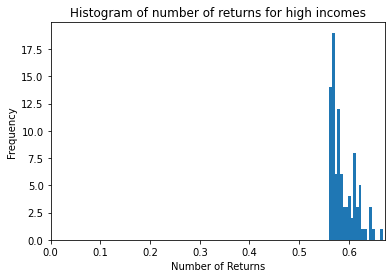

In [94]:
fig, ax = plt.subplots()

plt.hist(df["wealthy_prop"], 20)
ax.set_xlim(xmin=0)
plt.title("Histogram of number of returns for high incomes")
ax.set_xlabel("Number of Returns")
ax.set_ylabel("Frequency")
plt.show()

In [13]:
def get_lat(zipcode):
    zipcode = str(zipcode)
    nomi = pgeocode.Nominatim('US')
    df = nomi.query_postal_code(zipcode)
    return df["latitude"]

def get_long(zipcode):
    zipcode = str(zipcode)
    nomi = pgeocode.Nominatim('US')
    df = nomi.query_postal_code(zipcode)
    return df["longitude"]


In [96]:
df = both_large = pd.merge(df, large_ports, how = "outer")


df["zip_lat"] = df.apply(lambda row: get_lat(row.zipcode), axis = 1)
df["zip_long"] = df.apply(lambda row: get_long(row.zipcode), axis = 1)

df.head()

KeyboardInterrupt: 

In [52]:
both_large = pd.merge(df, large_ports, how = "cross", on = ["state"])
both_large = both_large.dropna()
both_large["zipcode"] = both_large["zipcode"].astype(int)

MergeError: Can not pass on, right_on, left_on or set right_index=True or left_index=True

In [55]:
both_large["large_distance"] = both_large.apply(lambda row: gp.geodesic((row.zip_lat, row.zip_long), (row.port_lat, row.port_long)).miles, axis = 1)
both_large = both_large.loc[both_large.groupby(by = "zipcode").large_distance.idxmin()].reset_index(drop=True)


## Join back together

Re-merge all of the dataframes to include zip codes with their closest large and small airport

In [56]:
large_dist = both_large[["zipcode", "large_distance", "name", "ident"]]
small_dist = both_small[["zipcode", "small_distance", "name", "ident"]]

both = both.set_index("zipcode").join(large_dist.set_index("zipcode"), how = "inner")
both = both.join(small_dist.set_index("zipcode"), how = "inner", lsuffix="_large", rsuffix="_small").reset_index()



# IGNORE BELOW

## Distribution of high net worth individuals

Create a histogram displaying the frequency of various buckets of numbers of high net worth returns filed.

High net worth is defined as the income bracket 5 ($100k-200k)

In [51]:
df = df[(df["zipcode"] != 99999) & (df["zipcode"] != 0) ]

high_nw = df[df["income"] == 5]
high_nw = high_nw.sort_values(by="returns", ascending=False)
high_nw = high_nw
high_nw.head()

,zipcode,hoh,singles,joint,wage,income,returns,state
143480,77494,630.0,1130.0,11140.0,1620683.0,5,13060.0,TX
143720,77573,620.0,1560.0,8980.0,1329994.0,5,11270.0,TX
143306,77433,620.0,1050.0,8520.0,1258792.0,5,10350.0,TX
17672,80134,510.0,1330.0,8080.0,1180923.0,5,10060.0,CO
16406,95747,580.0,1530.0,7810.0,1057365.0,5,10020.0,CA


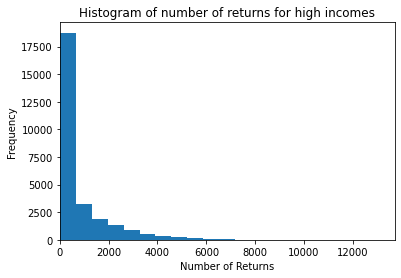

In [17]:
fig, ax = plt.subplots()

plt.hist(high_nw["returns"], 20)
ax.set_xlim(xmin=0)
plt.title("Histogram of number of returns for high incomes")
ax.set_xlabel("Number of Returns")
ax.set_ylabel("Frequency")
plt.show()

## Distribution of the top 100 high net worth zip codes

Plot the same distribution but only include the zip codes with the top 100 number of returns 

In [7]:
high_nw = high_nw[:100]

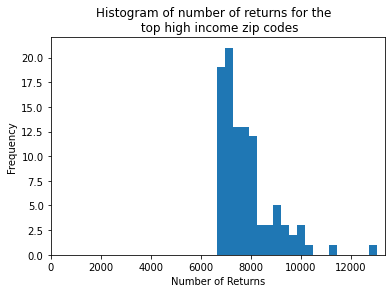

In [8]:
fig, ax = plt.subplots()

plt.hist(high_nw["returns"], 20)
ax.set_xlim(xmin=0)
plt.title("Histogram of number of returns for the  \n top high income zip codes")
ax.set_xlabel("Number of Returns")
ax.set_ylabel("Frequency")
plt.show()

### Conclusions

There is a significant right skew in the overall distribution of zip codes, and even within the top 100 highest number of returns, there is a long tail effect where the "wealthiest" zip codes (determined by the number of high net worth returns) are the least frequent

## Distribution of Ultra Wealthy returns
 
Define ultra wealthy as income level 6 ($200k+)

In [9]:
ultra_nw = df[df["income"] == 6]

ultra_nw = ultra_nw.sort_values(by="returns", ascending=False)
ultra_nw = ultra_nw



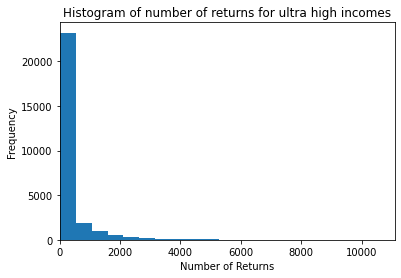

In [10]:
fig, ax = plt.subplots()

plt.hist(ultra_nw["returns"], 20)
ax.set_xlim(xmin=0)
plt.title("Histogram of number of returns for ultra high incomes")
ax.set_xlabel("Number of Returns")
ax.set_ylabel("Frequency")
plt.show()

## Distribution of top 100 ultra high net worth returns 

In [11]:
ultra_nw = ultra_nw[:100]

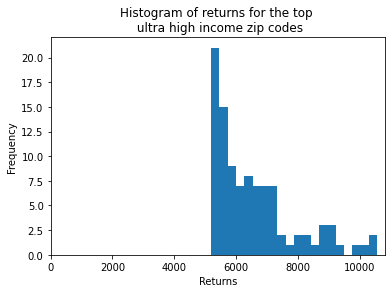

In [12]:
fig, ax = plt.subplots()

plt.hist(ultra_nw["returns"], 20)
ax.set_xlim(xmin=0)
plt.title("Histogram of returns for the top \n ultra high income zip codes")
ax.set_xlabel("Returns")
ax.set_ylabel("Frequency")
plt.show()

### Conclusion:

Similar as in ultra high net worth - long tail is seen in the wealthiest zip codes, even within the top 100. 

## Split income dataframes

We split the income dataframe into 3 groups based on which top 50 list the zip code appears in:
- Zip codes that are in both the high and ultra high nw top 50
- Zip codes that are only in the high nw top 50
- Zip codes that are only in the ultra high nw top 50

In [48]:
both = pd.merge(high_nw, ultra_nw, how='inner', on=['zipcode', 'state'], suffixes=("_high", "_ultra"))
both["zipcode"] = both["zipcode"].astype(int)
both.dropna(inplace=True)
both_list = list(both.zipcode)

both = high_nw[high_nw["zipcode"].isin(both_list)]
high_only = high_nw[~high_nw["zipcode"].isin(both_list)]
ultra_only = ultra_nw[~ultra_nw['zipcode'].isin(both_list)]

high_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 143720 to 143210
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   zipcode  71 non-null     int64  
 1   hoh      71 non-null     float64
 2   singles  71 non-null     float64
 3   joint    71 non-null     float64
 4   wage     71 non-null     float64
 5   income   71 non-null     int64  
 6   returns  71 non-null     float64
 7   state    71 non-null     object 
dtypes: float64(5), int64(2), object(1)
memory usage: 5.0+ KB


## Helper functions to get Lat-Long coordinates

In [50]:
both["zip_lat"] = both.apply(lambda row: get_lat(row.zipcode), axis = 1)
both["zip_long"] = both.apply(lambda row: get_long(row.zipcode), axis = 1)

<ipython-input-50-f31ea3603732>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both["zip_lat"] = both.apply(lambda row: get_lat(row.zipcode), axis = 1)
<ipython-input-50-f31ea3603732>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both["zip_long"] = both.apply(lambda row: get_long(row.zipcode), axis = 1)


## Re-form data for large and small airports

To get distance comparison, need each observation to contain a unique zip-code, airport pair. Repeat for both large and small airports

In [51]:
both_large = pd.merge(both, large_ports, how = 'outer')
both_large = both_large.dropna()
both_large["zipcode"] = both_large["zipcode"].astype(int)
both_large

,zipcode,hoh,singles,joint,wage,income,returns,state,zip_lat,zip_long,type,name,latitude_deg,longitude_deg,iso_country,ident,port_lat,port_long
0,77494,630.0,1130.0,11140.0,1620683.0,5.0,13060.0,TX,29.7404,-95.8304,large_airport,Fort Worth Alliance Airport,32.987598,-97.318802,US,KAFW,32.987598,-97.318802
1,77494,630.0,1130.0,11140.0,1620683.0,5.0,13060.0,TX,29.7404,-95.8304,large_airport,Rick Husband Amarillo International Airport,35.219398,-101.706001,US,KAMA,35.219398,-101.706001
2,77494,630.0,1130.0,11140.0,1620683.0,5.0,13060.0,TX,29.7404,-95.8304,large_airport,Austin Bergstrom International Airport,30.197535,-97.662015,US,KAUS,30.197535,-97.662015
3,77494,630.0,1130.0,11140.0,1620683.0,5.0,13060.0,TX,29.7404,-95.8304,large_airport,Corpus Christi International Airport,27.770399,-97.501198,US,KCRP,27.770399,-97.501198
4,77494,630.0,1130.0,11140.0,1620683.0,5.0,13060.0,TX,29.7404,-95.8304,large_airport,Dallas Love Field,32.847099,-96.851799,US,KDAL,32.847099,-96.851799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,60657,190.0,4140.0,2510.0,803793.0,5.0,7040.0,IL,41.9399,-87.6528,large_airport,Quad City International Airport,41.448502,-90.507500,US,KMLI,41.448502,-90.507500
274,60657,190.0,4140.0,2510.0,803793.0,5.0,7040.0,IL,41.9399,-87.6528,large_airport,Chicago O'Hare International Airport,41.978600,-87.904800,US,KORD,41.978600,-87.904800
275,60657,190.0,4140.0,2510.0,803793.0,5.0,7040.0,IL,41.9399,-87.6528,large_airport,General Wayne A. Downing Peoria International ...,40.664200,-89.693298,US,KPIA,40.664200,-89.693298
276,60657,190.0,4140.0,2510.0,803793.0,5.0,7040.0,IL,41.9399,-87.6528,large_airport,Chicago Rockford International Airport,42.195400,-89.097198,US,KRFD,42.195400,-89.097198


In [52]:
both_small = pd.merge(both, airports, how = "outer")
both_small = both_small.dropna()
both_small["zipcode"] = both_small["zipcode"].astype(int)
both_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17073 entries, 0 to 17180
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   zipcode        17073 non-null  int64  
 1   hoh            17073 non-null  float64
 2   singles        17073 non-null  float64
 3   joint          17073 non-null  float64
 4   wage           17073 non-null  float64
 5   income         17073 non-null  float64
 6   returns        17073 non-null  float64
 7   state          17073 non-null  object 
 8   zip_lat        17073 non-null  float64
 9   zip_long       17073 non-null  float64
 10  type           17073 non-null  object 
 11  name           17073 non-null  object 
 12  latitude_deg   17073 non-null  float64
 13  longitude_deg  17073 non-null  float64
 14  iso_country    17073 non-null  object 
 15  ident          17073 non-null  object 
 16  port_lat       17073 non-null  float64
 17  port_long      17073 non-null  float64
dtypes: flo

## Get distance

Apply the distance function, and select only the airports that are closest to the zip code. 

Repeat for large and small airports

## Display results

**NOTE: Because of the way the aggregations were performed, the zipcode-airport pairs with the greatest distance are outliers. This occurs because the closest airports to 20147 and 20148 are in a different state.**

In [59]:
both.sort_values(by = "large_distance", ascending=False)[["zipcode", "state", "returns", "name_large", "large_distance","name_small", "small_distance"]]

,zipcode,state,returns,name_large,large_distance,name_small,small_distance
6,20147,VA,8210.0,Richmond International Airport,106.034935,Leesburg Executive Airport,5.003406
24,20148,VA,6970.0,Richmond International Airport,104.697906,Leesburg Executive Airport,4.669355
0,77494,TX,13060.0,William P Hobby Airport,33.805125,Covey Trails Airport,3.516124
16,20878,MD,7440.0,Joint Base Andrews,29.358834,Montgomery County Airpark,5.992810
3,95630,CA,9510.0,Sacramento International Airport,23.746860,Cameron Park Airport,8.961965
1,77433,TX,10350.0,George Bush Intercontinental Houston Airport,22.749021,West Houston Airport,4.849311
2,75035,TX,9900.0,Dallas Love Field,20.841472,Aero Country Airport,4.914845
4,77479,TX,9410.0,William P Hobby Airport,20.253925,Sugar Land Regional Airport,4.257106
9,80016,CO,7850.0,Denver International Airport,18.316690,Centennial Airport,6.231501
18,94568,CA,7360.0,Metropolitan Oakland International Airport,16.350861,Livermore Municipal Airport,5.845157
